# Credit Card Fraud Detection Project

## Introduction
Credit card fraud is a significant issue in today’s world of digital transactions. Detecting fraudulent transactions is critical for financial institutions to minimise losses and protect customers. The focus of this project is to build and evaluate machine learning models that can detect fraudulent credit card transactions using the Credit Card Fraud Detection dataset. One of the challenges in fraud detection is the highly imbalanced nature of the data—fraudulent transactions are rare compared to legitimate ones. Hence, we will explore different models and evaluate them using appropriate metrics such as precision, recall, F1-score, and AUC-ROC. These metrics help us assess the models' ability to balance false positives and false negatives, which is critical in fraud detection.

## Data Overview
The dataset used in this project is the Credit Card Fraud Detection dataset, which consists of 284,807 transactions, with only 492 labeled as fraudulent (Class 1). Each transaction is represented by 30 anonymised numerical features, and the target variable is binary: '0' for non-fraudulent and '1' for fraudulent transactions.
- Features: 30 anonymised numerical variables.
- Target: 'Class' (0 = not fraud, 1 = fraud).

## Data Preprocessing
Data preprocessing is a crucial step to prepare the dataset for model training. We performed the following steps:
- Standardisation: The Amount feature was standardised to remove scale differences.
- Feature Removal: The Time feature, which was not useful in prediction, was removed.
- Train-Test Split: The data was split into an 80-20 ratio for training and testing.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier, plot_tree
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.ensemble import GradientBoostingClassifier

2024-09-15 16:45:25.381722: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the data
credit_data = pd.read_csv('creditcard.csv')

# Standardise the 'Amount' column
scaler = StandardScaler()
credit_data['Amount'] = scaler.fit_transform(credit_data[['Amount']])

# Remove the 'Time' column
new_data = credit_data.drop(columns=['Time'])

# Separate features and target variable
X = new_data.drop('Class', axis=1)
y = new_data['Class']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Logistic Regression Model
Logistic Regression serves as the baseline model. This simple yet effective algorithm is useful for understanding the dataset and setting a foundation for more complex models.

### Residual Analysis
I checked the model fit using residual analysis, where residuals are the differences between observed and predicted values.

In [3]:
# Train the Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train, y_train)

# Predict probabilities and calculate residuals
fitted_values = logistic_model.predict_proba(X_train)[:, 1] # Probability of class 1 (fraudulent)
residuals = y_train - fitted_values

To visualise model fit, I used three plots:
- Residuals vs. Fitted Plot: Helps detect patterns in the residuals to see if the model fits well.
- Normal Q-Q Plot: Shows if the residuals are normally distributed, which is an indicator of good model fit.
- Scale-Location Plot: Highlights heteroscedasticity (i.e., if variance is constant across the range of predictions).

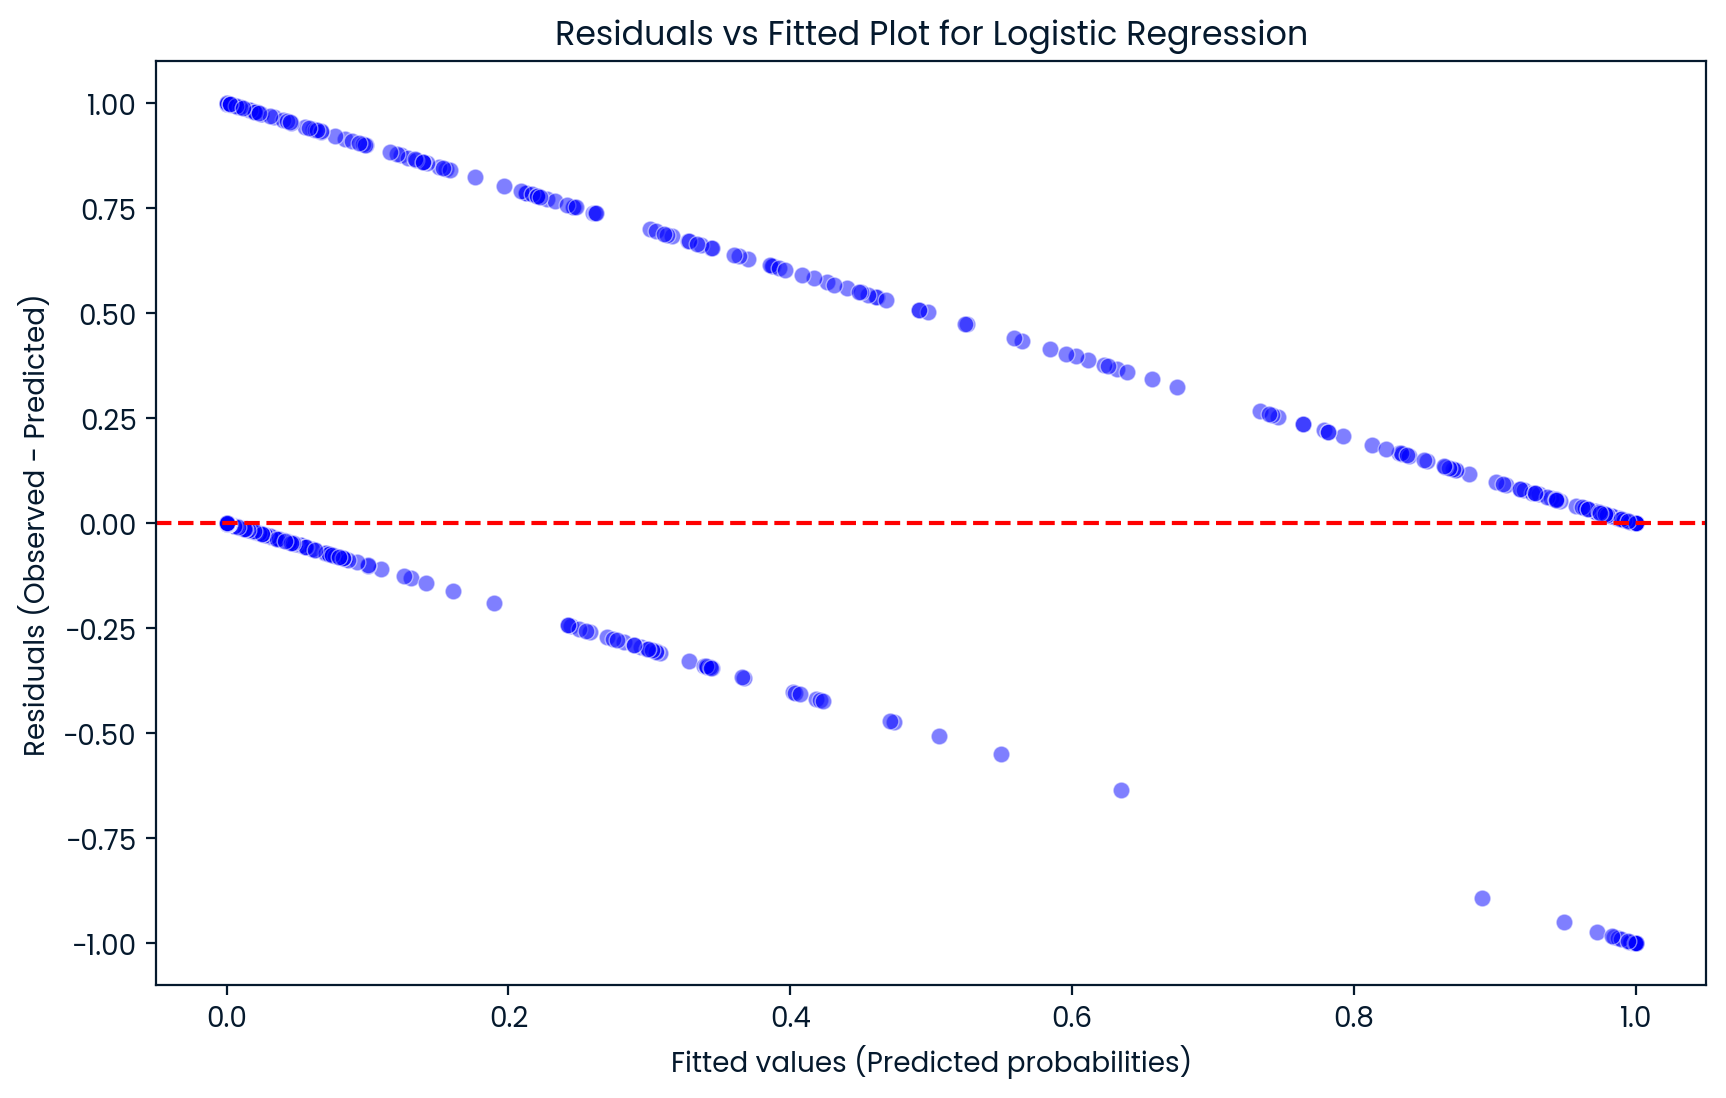

In [4]:
# Create the Residuals vs Fitted plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=fitted_values, y=residuals, color="blue", alpha=0.5)
plt.title('Residuals vs Fitted Plot for Logistic Regression')
plt.xlabel('Fitted values (Predicted probabilities)')
plt.ylabel('Residuals (Observed - Predicted)')
plt.axhline(0, color='red', linestyle='--')
plt.show()

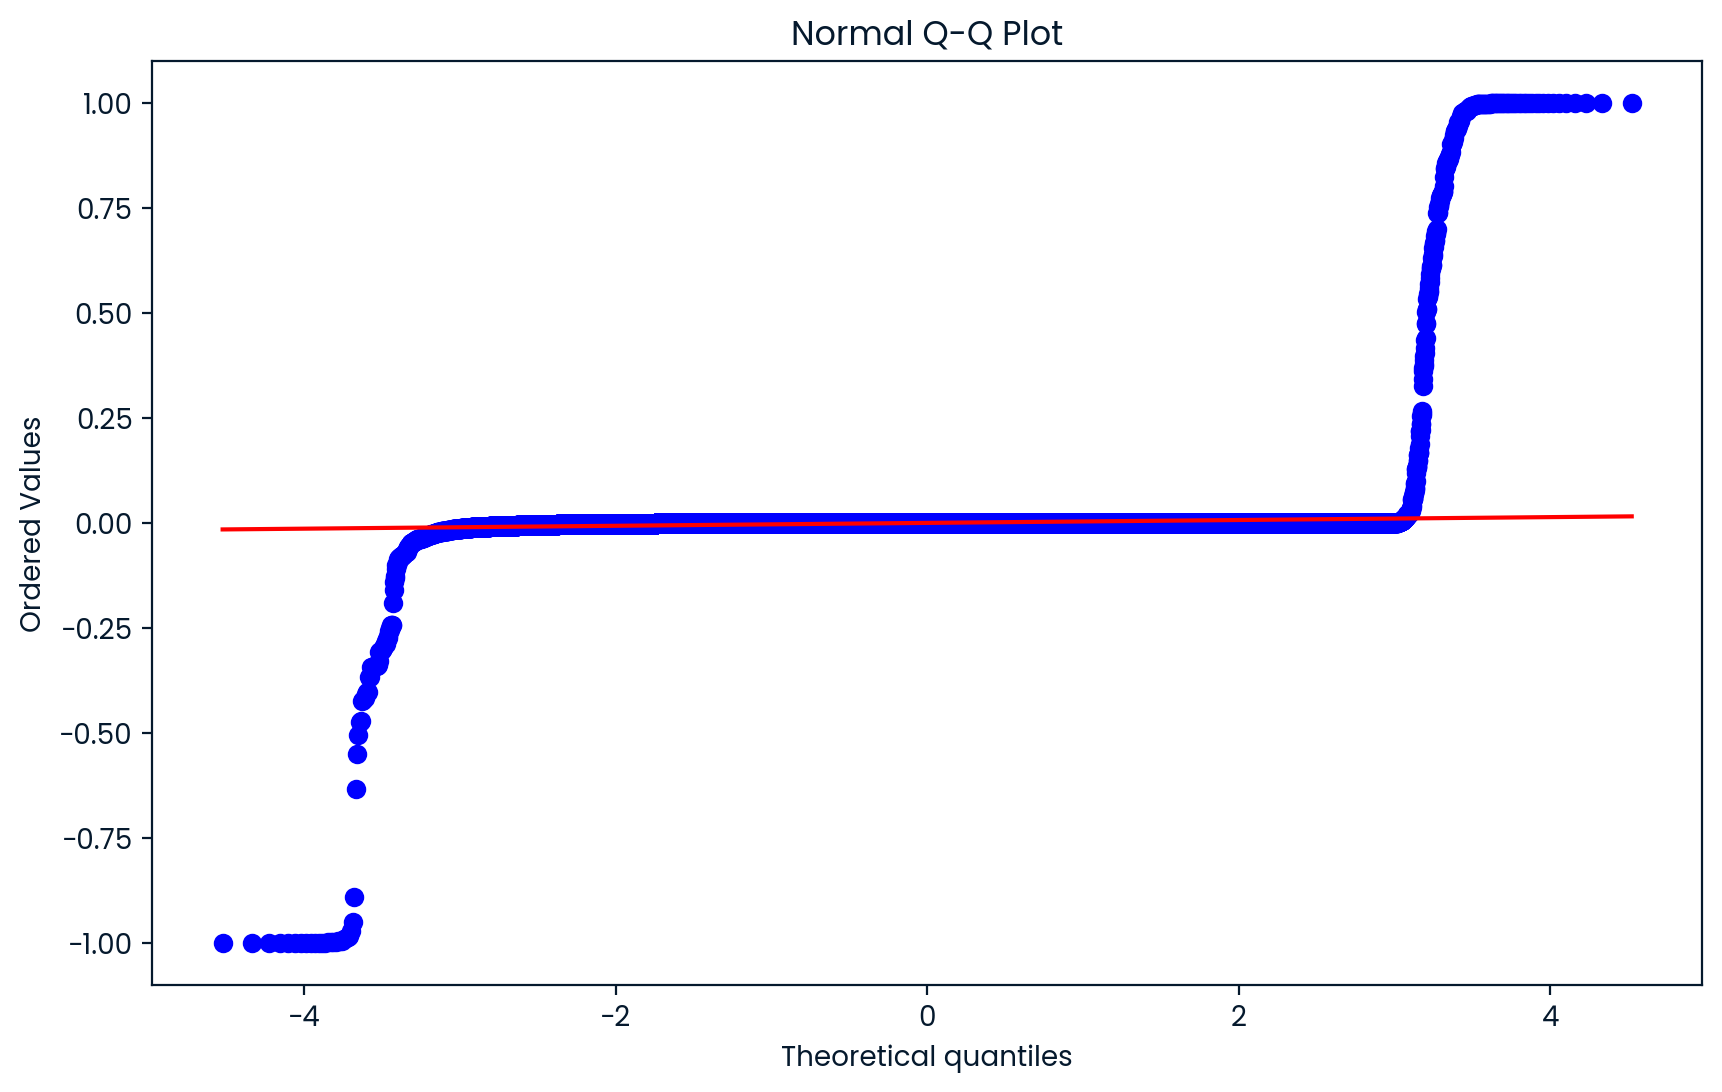

In [5]:
# Q-Q plot of the residuals
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Normal Q-Q Plot')
plt.show()

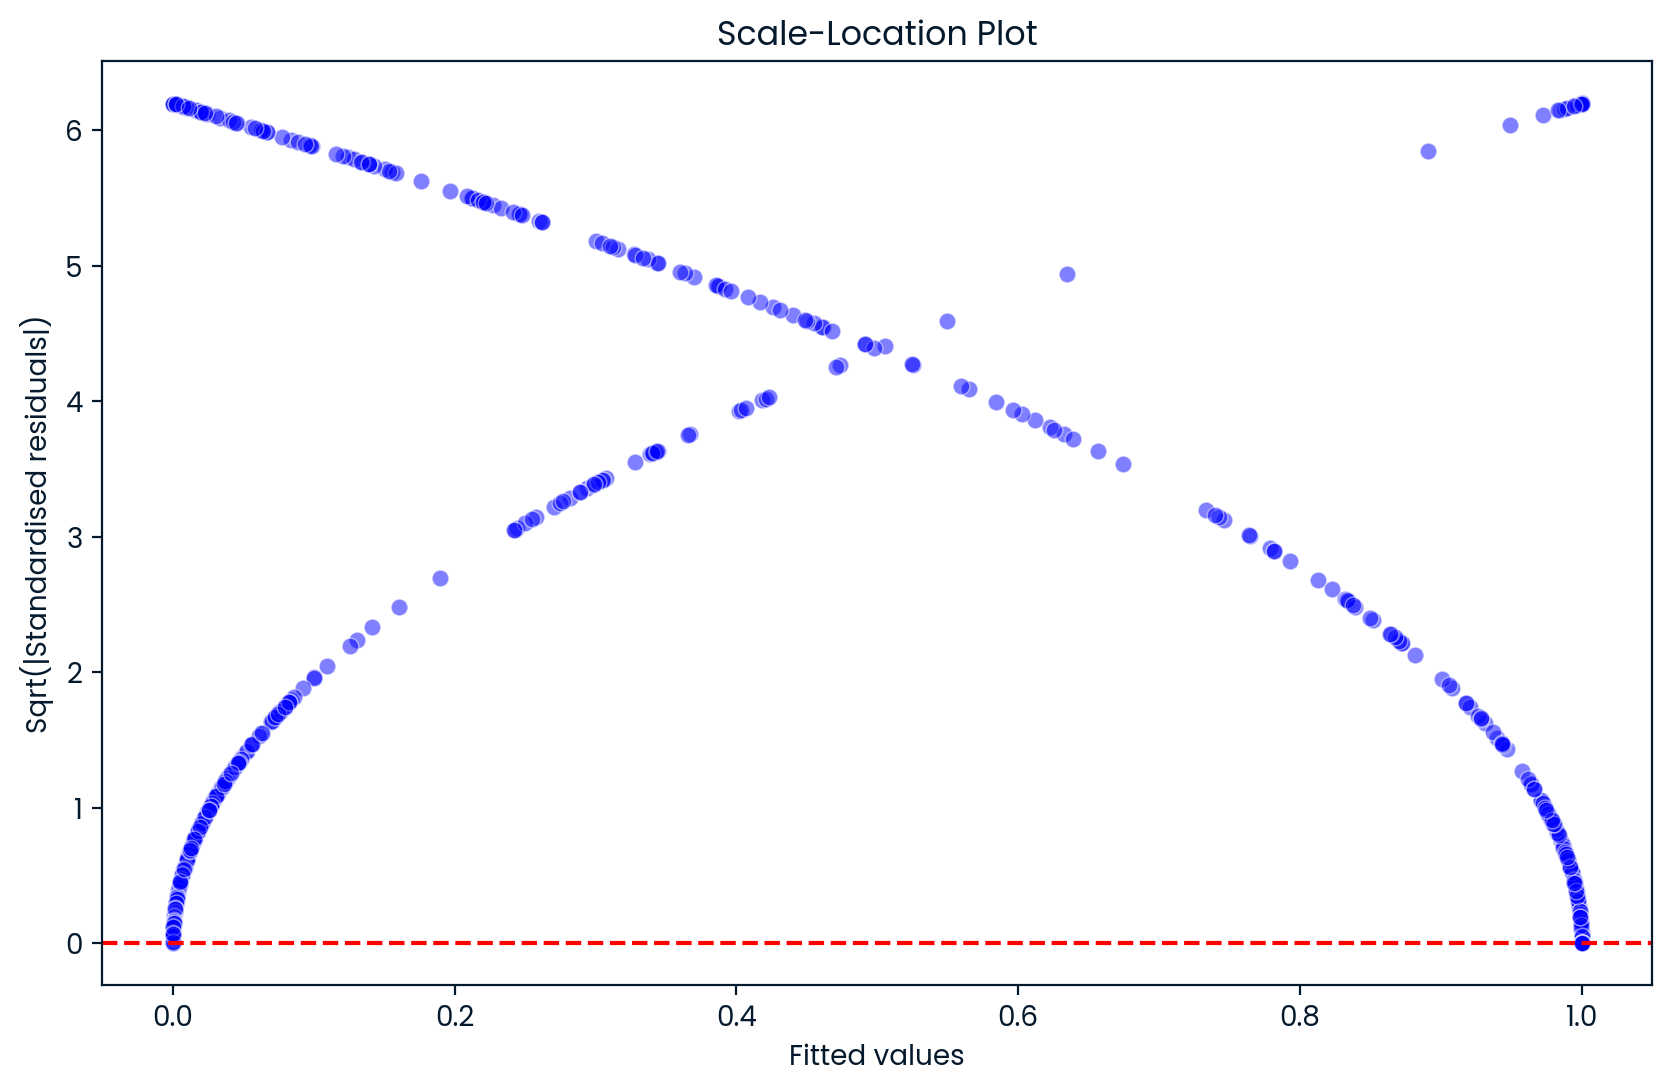

In [6]:
# Square root of standardised residuals
standardised_residuals = residuals / np.std(residuals)
# Scale-Location plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=fitted_values, y=np.sqrt(np.abs(standardised_residuals)), color="blue", alpha=0.5)
plt.title('Scale-Location Plot')
plt.xlabel('Fitted values')
plt.ylabel('Sqrt(|Standardised residuals|)')
plt.axhline(0, color='red', linestyle='--')
plt.show()

### Evaluation
I also plotted the ROC Curve to measure model performance on the test data. The model performed well, demonstrating good separation between classes on the ROC Curve with an AUC score of 0.98.

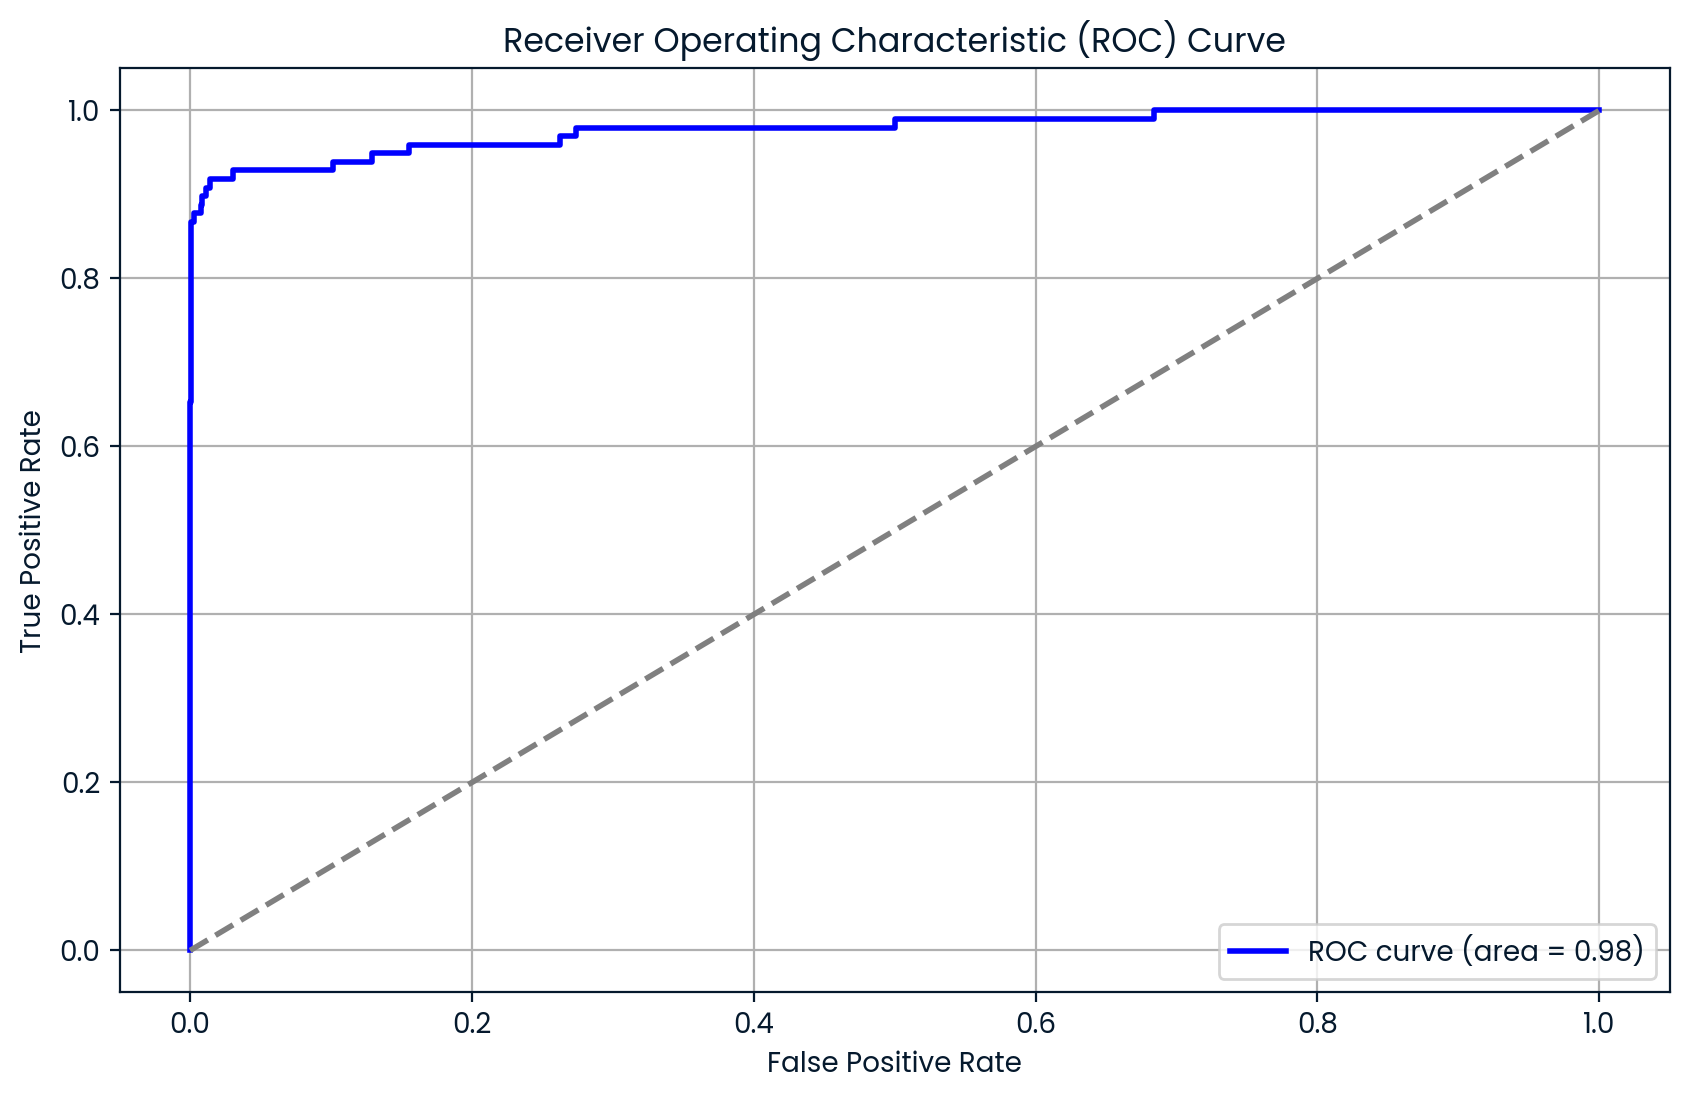

In [7]:
# ROC Curve and AUC Score
fpr, tpr, thresholds = roc_curve(y_test, logistic_model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=2)
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Decision Tree Model
Next, I trained a Decision Tree Classifier, which is capable of handling non-linear relationships and providing insight into feature importance.

In [8]:
# Train the Decision Tree model
decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

### Evaluation
- Accuracy: 99.91%.
- Precision & Recall: The model achieved good precision and recall for class 1 (fraudulent transactions), despite the class imbalance.

In [9]:
# Evaluate the model on test data
y_test_pred = decision_tree_model.predict(X_test)

# Performance metrics
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

Test Accuracy: 0.9991

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.70      0.78      0.74        98

    accuracy                           1.00     56962
   macro avg       0.85      0.89      0.87     56962
weighted avg       1.00      1.00      1.00     56962



A decision tree visualisation was created to show the model’s decision-making process up to a limited depth for clarity.

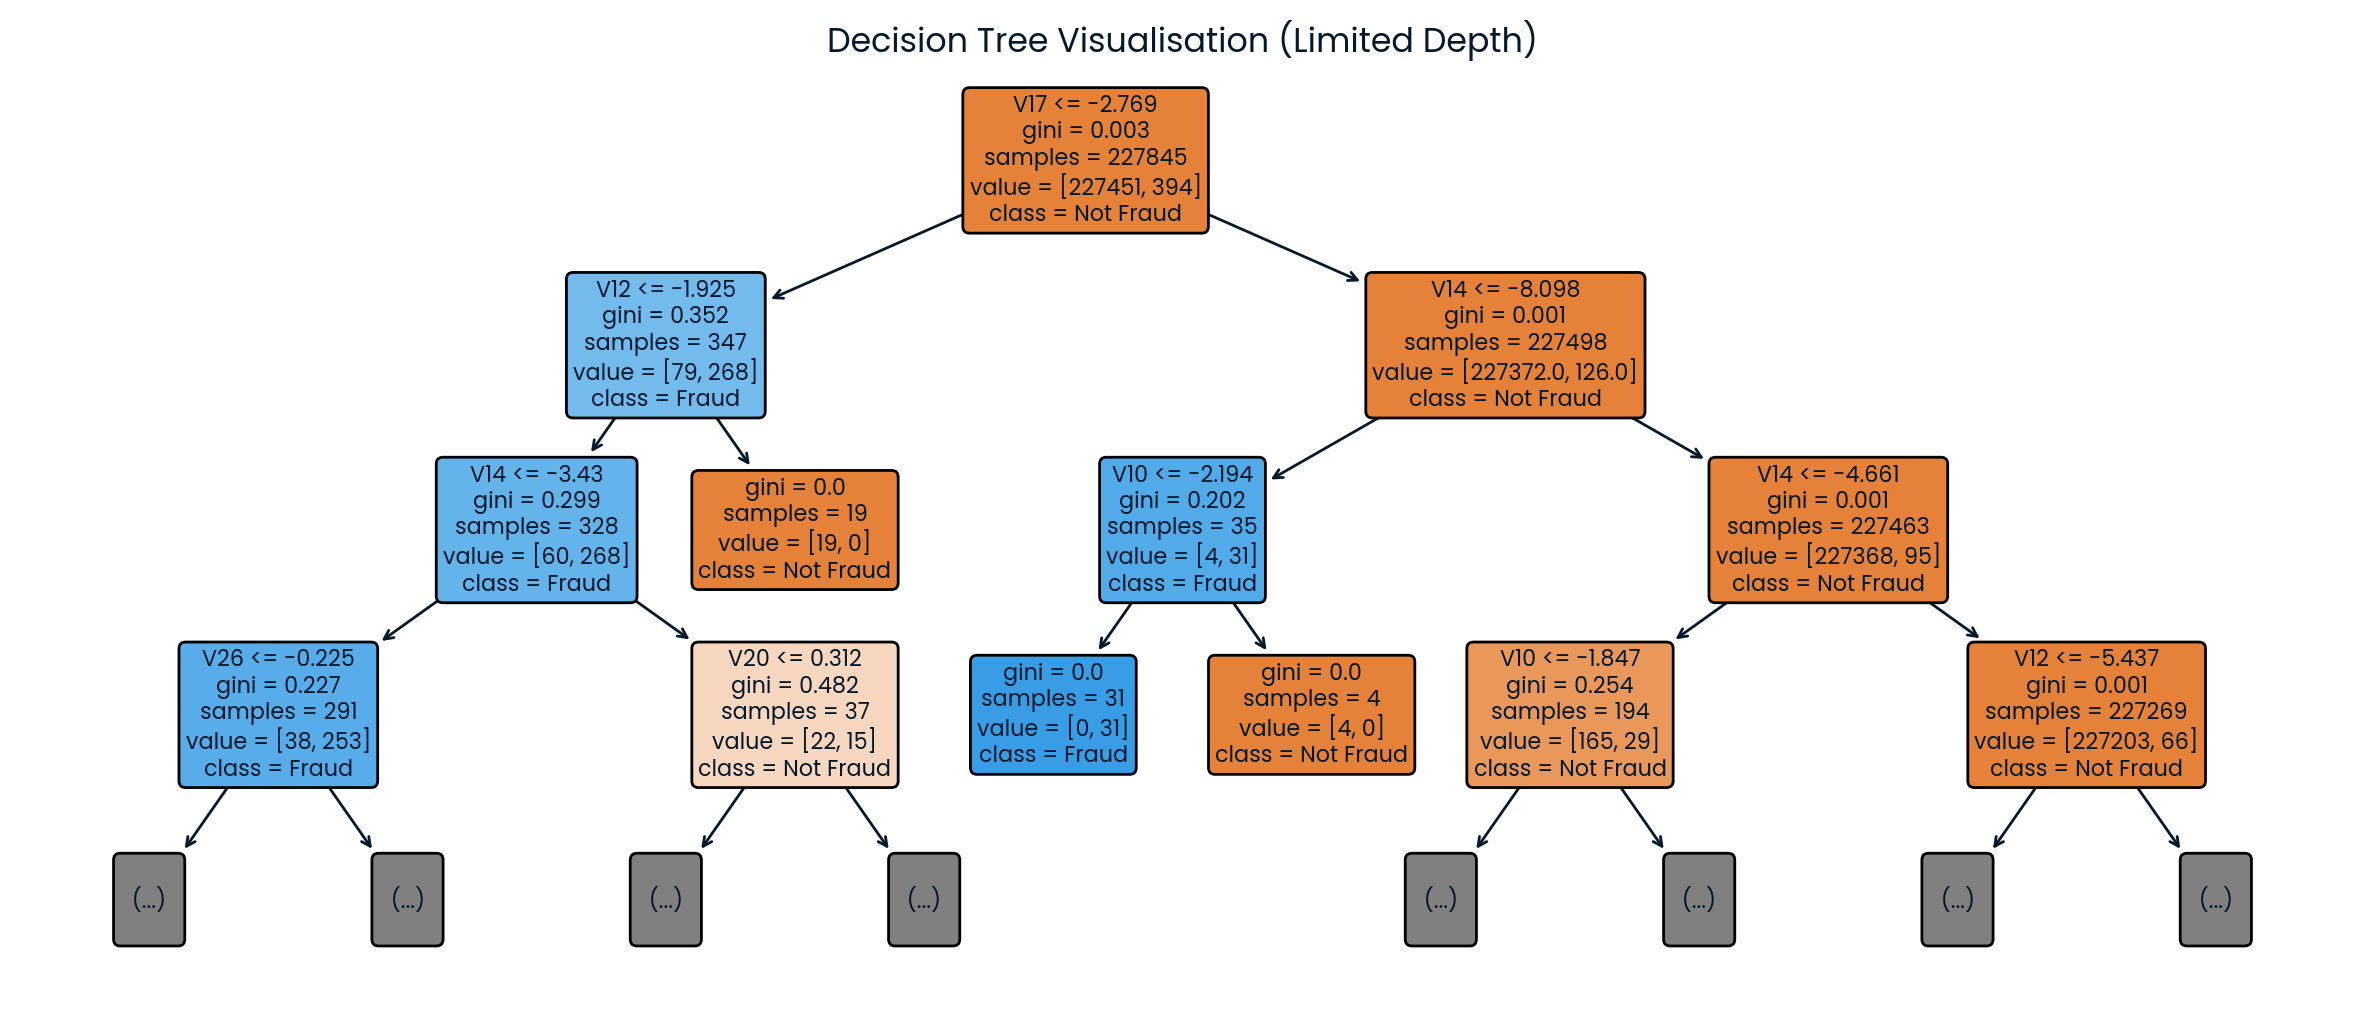

In [23]:
# Plot a subtree of the decision tree
plt.figure(figsize=(15, 6))
plot_tree(decision_tree_model, 
          feature_names=X_train.columns, 
          class_names=['Not Fraud', 'Fraud'], 
          filled=True, 
          rounded=True, 
          max_depth=3,
          fontsize=8)
plt.title('Decision Tree Visualisation (Limited Depth)')
plt.show()

## Artificial Neural Network (ANN)
Next, I experimented with a Neural Network. ANNs are powerful models that capture complex patterns in the data. However, they require more training time and resources.

In [24]:
# Define and compile the model
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 7s 939us/step - accuracy: 0.9782 - loss: 0.0560 - val_accuracy: 0.9993 - val_loss: 0.0033
Epoch 2/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 6s 906us/step - accuracy: 0.9993 - loss: 0.0030 - val_accuracy: 0.9993 - val_loss: 0.0028
Epoch 3/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 6s 902us/step - accuracy: 0.9994 - loss: 0.0027 - val_accuracy: 0.9994 - val_loss: 0.0027
Epoch 4/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 6s 907us/step - accuracy: 0.9994 - loss: 0.0022 - val_accuracy: 0.9993 - val_loss: 0.0028
Epoch 5/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 7s 915us/step - accuracy: 0.9994 - loss: 0.0029 - val_accuracy: 0.9994 - val_loss: 0.0027
Epoch 6/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 6s 906us/step - accuracy: 0.9995 - loss: 0.0022 - val_accuracy: 0.9993 - val_loss: 0.0029
Epoch 7/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 6s 902us/step - accuracy: 0.9994 - loss: 0.0023 - val_accuracy: 0.9994 - val_loss: 0.0027
Epoch 8/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 6s 906us/step - accuracy: 0.9995 -

### Evaluation
- The neural network achieved an impressive AUC score of 0.99, indicating excellent performance in detecting fraudulent transactions.
- Confusion Matrix: Showed high accuracy, with very few false positives and false negatives.

In [25]:
# Predict and evaluate the model
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Confusion Matrix and AUC
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC: {roc_auc:.2f}")

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 614us/step
Confusion Matrix:
[[56858     6]
 [   28    70]]
ROC AUC: 0.99


## Gradient Boosting Model
Finally, I trained a Gradient Boosting Classifier, which combines weak learners into a strong model. It is known for being effective in handling complex data patterns.

In [26]:
# Train the Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

### Evaluation
- AUC-ROC: 0.79.
- Although the model performed well, its AUC score was lower compared to Logistic Regression and ANN, indicating it might have struggled with the class imbalance.

Confusion Matrix:
[[56843    21]
 [   39    59]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.74      0.60      0.66        98

    accuracy                           1.00     56962
   macro avg       0.87      0.80      0.83     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC: 0.79


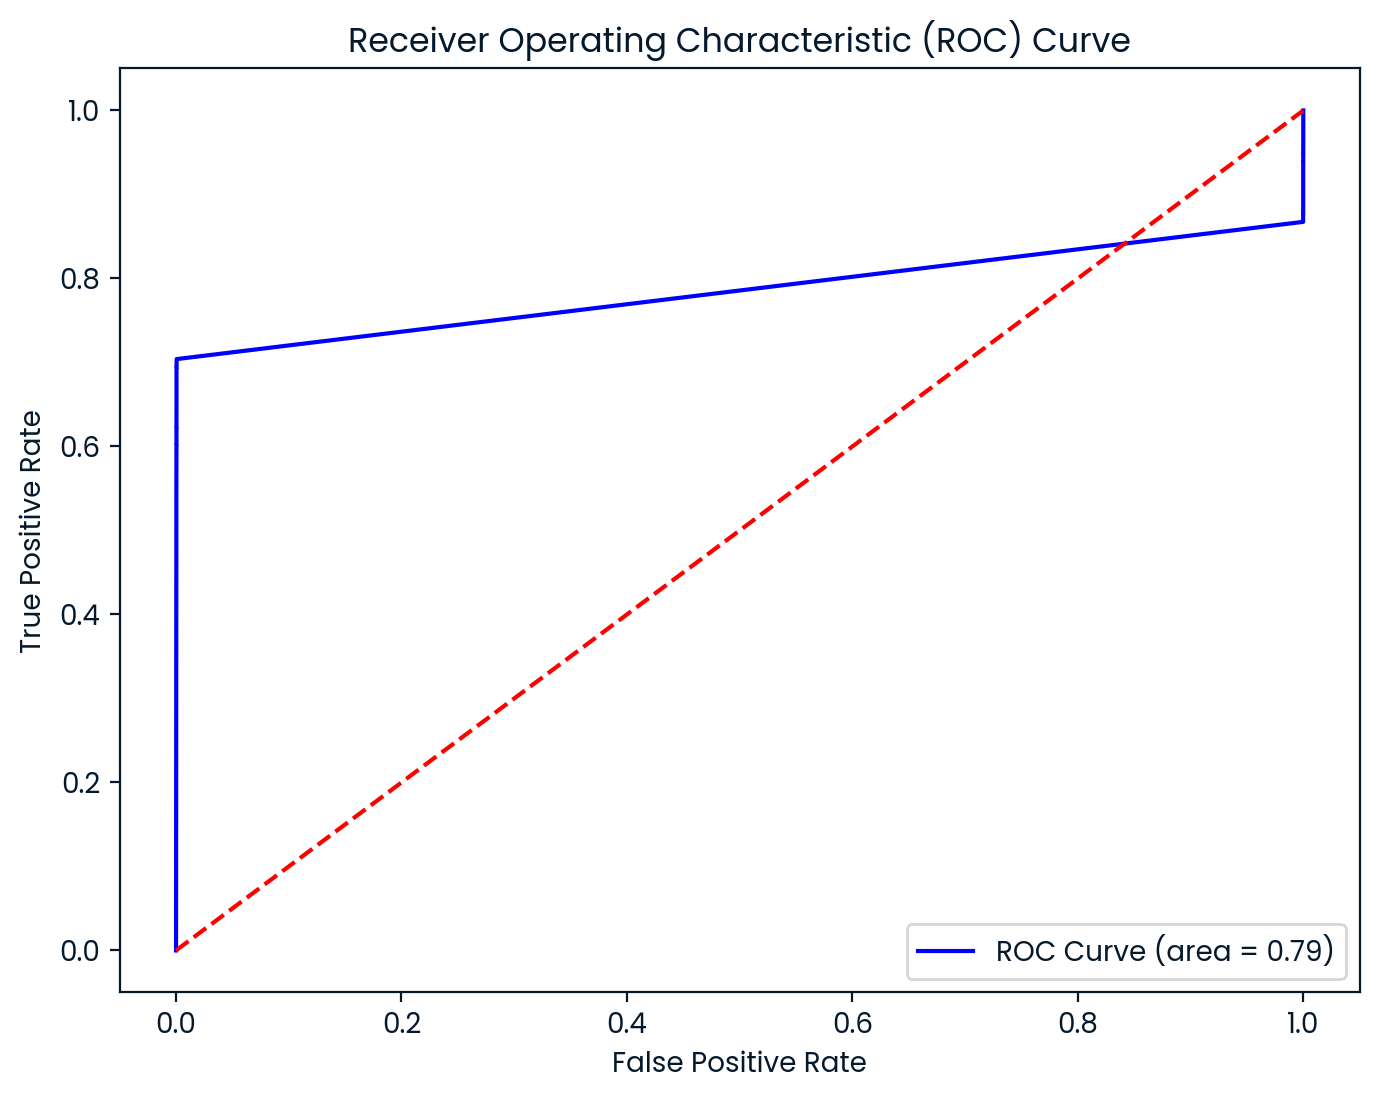

In [28]:
# Make predictions
y_pred = gb_model.predict(X_test)
y_pred_prob = gb_model.predict_proba(X_test)[:, 1]  # Get probabilities for the ROC curve

# Confusion Matrix and Classification Report
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Evaluate model and plot ROC curve
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Conclusion
In this credit card fraud detection project, we evaluated multiple machine learning models to address the challenge of identifying fraudulent transactions within a highly imbalanced dataset. The Artificial Neural Network (ANN) outperformed other models, achieving an AUC-ROC score of 0.99, demonstrating its ability to capture complex, non-linear patterns in the data. However, ANN's complexity and lack of interpretability may limit its use in real-world applications where transparency is crucial. Logistic Regression provided a strong baseline with a similarly high AUC-ROC score of 0.98, making it a more interpretable and efficient option for many business scenarios. The Decision Tree model, whilst offering good accuracy and visual interpretability, struggled slightly with precision and recall for the minority class. Although Gradient Boosting underperformed with an AUC-ROC of 0.79, it may benefit from techniques like SMOTE to handle the class imbalance more effectively. 

Overall, each model presents trade-offs between complexity, interpretability, and performance, with ANN being the most accurate but least interpretable, and Logistic Regression offering a simpler yet highly effective solution. Future improvements, such as oversampling or cost-sensitive learning, could enhance the detection of fraudulent transactions, making these models more robust in practical applications.